In [1]:
# Created on June 13, 2023
# Author: Jung Hun Oh
# github: https://github.com/MSK-MOI/NWK

## Install OMT and CVX packages

In [2]:
!pip install pot
!pip install cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 42.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy.matlib
%matplotlib inline

import math
from sklearn import set_config
from sklearn.impute import SimpleImputer

import networkx as nx
from networkx.algorithms import dfs_labeled_edges

import ot
import cvxpy as cp

set_config(display="text") 

## Import the unblanced OMT library

In [4]:
from UnbalancedOMT import UnbalancedOMT

## Read radiomic data

In [5]:
df_all = pd.read_csv("lung_data_red.csv") 
df_red = df_all.iloc[:,1:len(df_all.columns)] 

In [6]:
df_all

,id,Shape_volume,Shape_flatness,Shape_elongation,Shape_Compactness1,Shape_Compactness2,Shape_spherDisprop,Shape_sphericity,Original_firstOrderS_min,Original_firstOrderS_max,...,Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_skewness,Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_kurtosis,Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_entropy,Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_rms,Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_meanAbsDev,Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_medianAbsDev,Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_P90,Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_robustMeanAbsDev,Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_robustMedianAbsDev,Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_interQuartileRange
0,R01-003,1.459,0.66935,0.72818,0.035321,0.44327,1.3115,0.76247,1.000000,0.152262,...,0.080424,0.287728,5.4487,4683.7,889.91,879.66,5893.6,585.78,583.50,1345.6
1,R01-004,1.343,0.38130,0.61655,0.024889,0.22009,1.6563,0.60377,0.721411,0.156110,...,0.161999,0.188468,5.5763,4308.0,1021.90,1013.60,5667.0,697.72,695.20,1652.3
2,R01-005,7.109,0.67319,0.78334,0.030942,0.34018,1.4325,0.69808,0.953038,0.179764,...,0.279556,0.000692,5.7463,3381.2,1518.10,1507.50,5020.5,1233.40,1222.00,3082.3
3,R01-006,4.155,0.62502,0.81920,0.025983,0.23987,1.6094,0.62133,0.748129,0.083540,...,0.307802,0.176480,5.5981,3373.2,950.99,950.26,4604.7,655.76,655.34,1564.7
4,R01-007,1.233,0.83261,0.91407,0.033361,0.39544,1.3624,0.73400,0.557750,0.191318,...,0.047033,0.281972,5.4992,4725.9,854.02,843.47,5821.0,583.95,580.90,1397.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,R01-141,7.584,0.48395,0.62451,0.024536,0.21389,1.6721,0.59804,0.348689,0.275460,...,0.262422,0.185369,5.2822,4223.2,831.48,830.17,5394.7,581.42,580.85,1394.3
113,R01-142,24.831,0.63785,0.70415,0.026087,0.24180,1.6051,0.62300,0.416370,0.191557,...,0.346804,0.153526,5.4231,2658.7,826.51,826.30,3773.3,586.83,586.64,1402.2
114,R01-144,5.061,0.47911,0.95243,0.020847,0.15442,1.8639,0.53650,0.380758,0.174060,...,0.338222,0.106389,5.5677,3842.4,913.23,912.97,5152.9,665.66,665.36,1604.8
115,R01-145,24.587,0.80275,0.90805,0.019436,0.13422,1.9531,0.51201,0.350784,0.558570,...,0.289434,0.072961,5.4843,3392.1,1296.80,1289.50,4901.2,983.61,976.53,2357.6


## Read adjacency matrix

In [7]:
corr_data = pd.read_csv("EBICgraph.csv")
corr_data = corr_data.iloc[:,1:len(corr_data.columns)] 

## Compute Spearman correlation coefficients

In [8]:
from scipy import stats
df_corr = pd.DataFrame() # Correlation matrix
df_p = pd.DataFrame()  # Matrix of p-values
for x in df_red.columns:
    for y in df_red.columns:
        corr = stats.spearmanr(df_red[x], df_red[y])
        df_corr.loc[x,y] = corr[0]
        df_p.loc[x,y] = corr[1]

for x in range(len(df_red.columns)):
    for y in range(len(df_red.columns)):
      df_corr.iloc[x,y]=corr_data.iloc[x,y]
print(df_corr)

<ipython-input-8-d0397fb6aa00>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_corr.loc[x,y] = corr[0]
<ipython-input-8-d0397fb6aa00>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_p.loc[x,y] = corr[1]
<ipython-input-8-d0397fb6aa00>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_corr.lo

                                                    Shape_volume  \
Shape_volume                                                 0.0   
Shape_flatness                                               0.0   
Shape_elongation                                             0.0   
Shape_Compactness1                                           0.0   
Shape_Compactness2                                           0.0   
...                                                          ...   
Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_Orien...           0.0   
Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_Orien...           0.0   
Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_Orien...           0.0   
Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_Orien...           0.0   
Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_Orien...           0.0   

                                                    Shape_flatness  \
Shape_volume                                              0.000000   
Shape_flatness                             

## Draw the entire network

Index(['Shape_volume', 'Shape_flatness', 'Shape_elongation',
       'Shape_Compactness1', 'Shape_Compactness2', 'Shape_spherDisprop',
       'Shape_sphericity', 'Original_firstOrderS_min',
       'Original_firstOrderS_max', 'Original_firstOrderS_mean',
       ...
       'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_skewness',
       'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_kurtosis',
       'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_entropy',
       'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_rms',
       'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_meanAbsDev',
       'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_medianAbsDev',
       'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_P90',
       'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firs

<ipython-input-9-a2cee2243d09>:14: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G), node_size=20, \


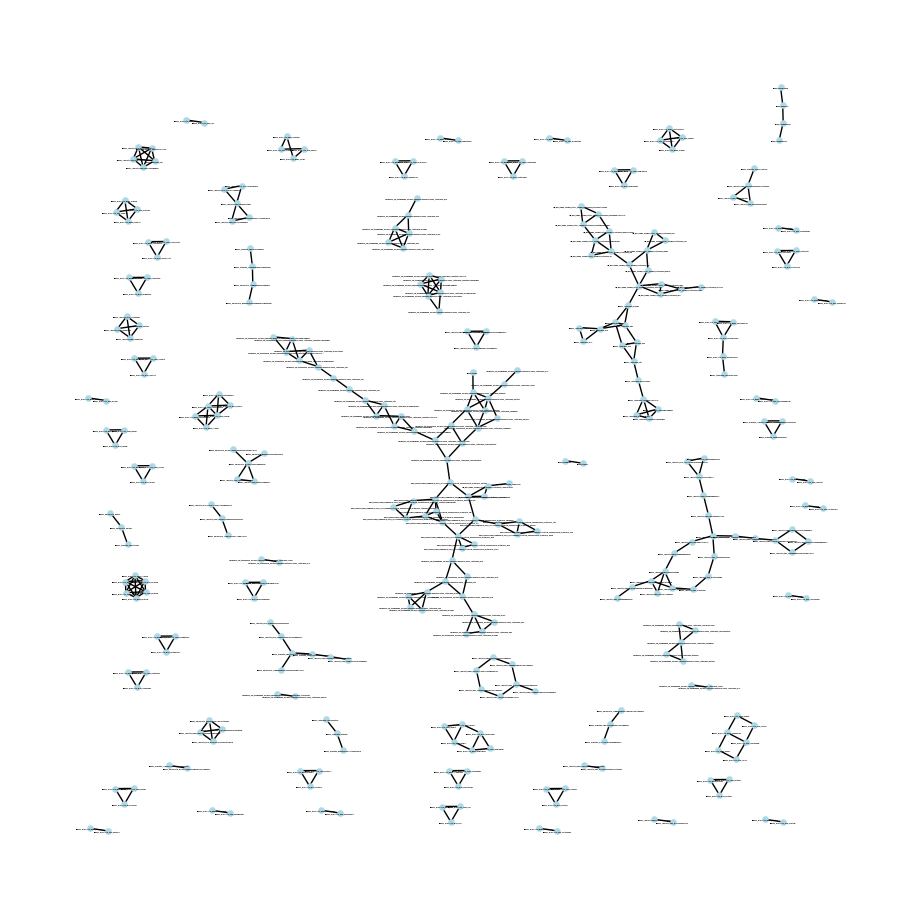

In [9]:
cor_matrix = np.asmatrix(df_corr)
n=len(df_red.columns) 
variables=df_red.columns 
print(variables)
threshold=0.15 # Threshold of partial correlation
G=nx.Graph()

for i in range(n):
    for j in range(n):
      if i> j and abs(cor_matrix[i,j]) > threshold:
        G.add_edge(variables[i],variables[j], weight=1)

plt.figure(1,figsize=(9,9)) 
nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G), node_size=20, \
    node_color='lightblue', linewidths=0.25, font_size=0.1, \
    font_weight='bold', with_labels=True )
adj = nx.adjacency_matrix(G)

# Find a largest network component

<ipython-input-10-1cff6242a7b2>:4: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(G0, pos = nx.nx_pydot.graphviz_layout(G0), node_size=100, \


  (0, 3)	1
  (0, 28)	1
  (0, 34)	1
  (0, 50)	1
  (1, 36)	1
  (1, 52)	1
  (1, 58)	1
  (2, 25)	1
  (2, 46)	1
  (2, 51)	1
  (3, 0)	1
  (3, 34)	1
  (3, 50)	1
  (4, 17)	1
  (4, 19)	1
  (4, 31)	1
  (5, 11)	1
  (5, 16)	1
  (5, 55)	1
  (5, 56)	1
  (6, 19)	1
  (6, 32)	1
  (6, 54)	1
  (7, 20)	1
  (7, 28)	1
  :	:
  (50, 45)	1
  (51, 2)	1
  (51, 25)	1
  (51, 32)	1
  (51, 46)	1
  (52, 1)	1
  (52, 10)	1
  (52, 26)	1
  (53, 38)	1
  (53, 41)	1
  (53, 48)	1
  (53, 57)	1
  (54, 6)	1
  (54, 37)	1
  (55, 5)	1
  (55, 16)	1
  (56, 5)	1
  (56, 11)	1
  (56, 43)	1
  (57, 24)	1
  (57, 38)	1
  (57, 53)	1
  (58, 1)	1
  (58, 12)	1
  (58, 45)	1


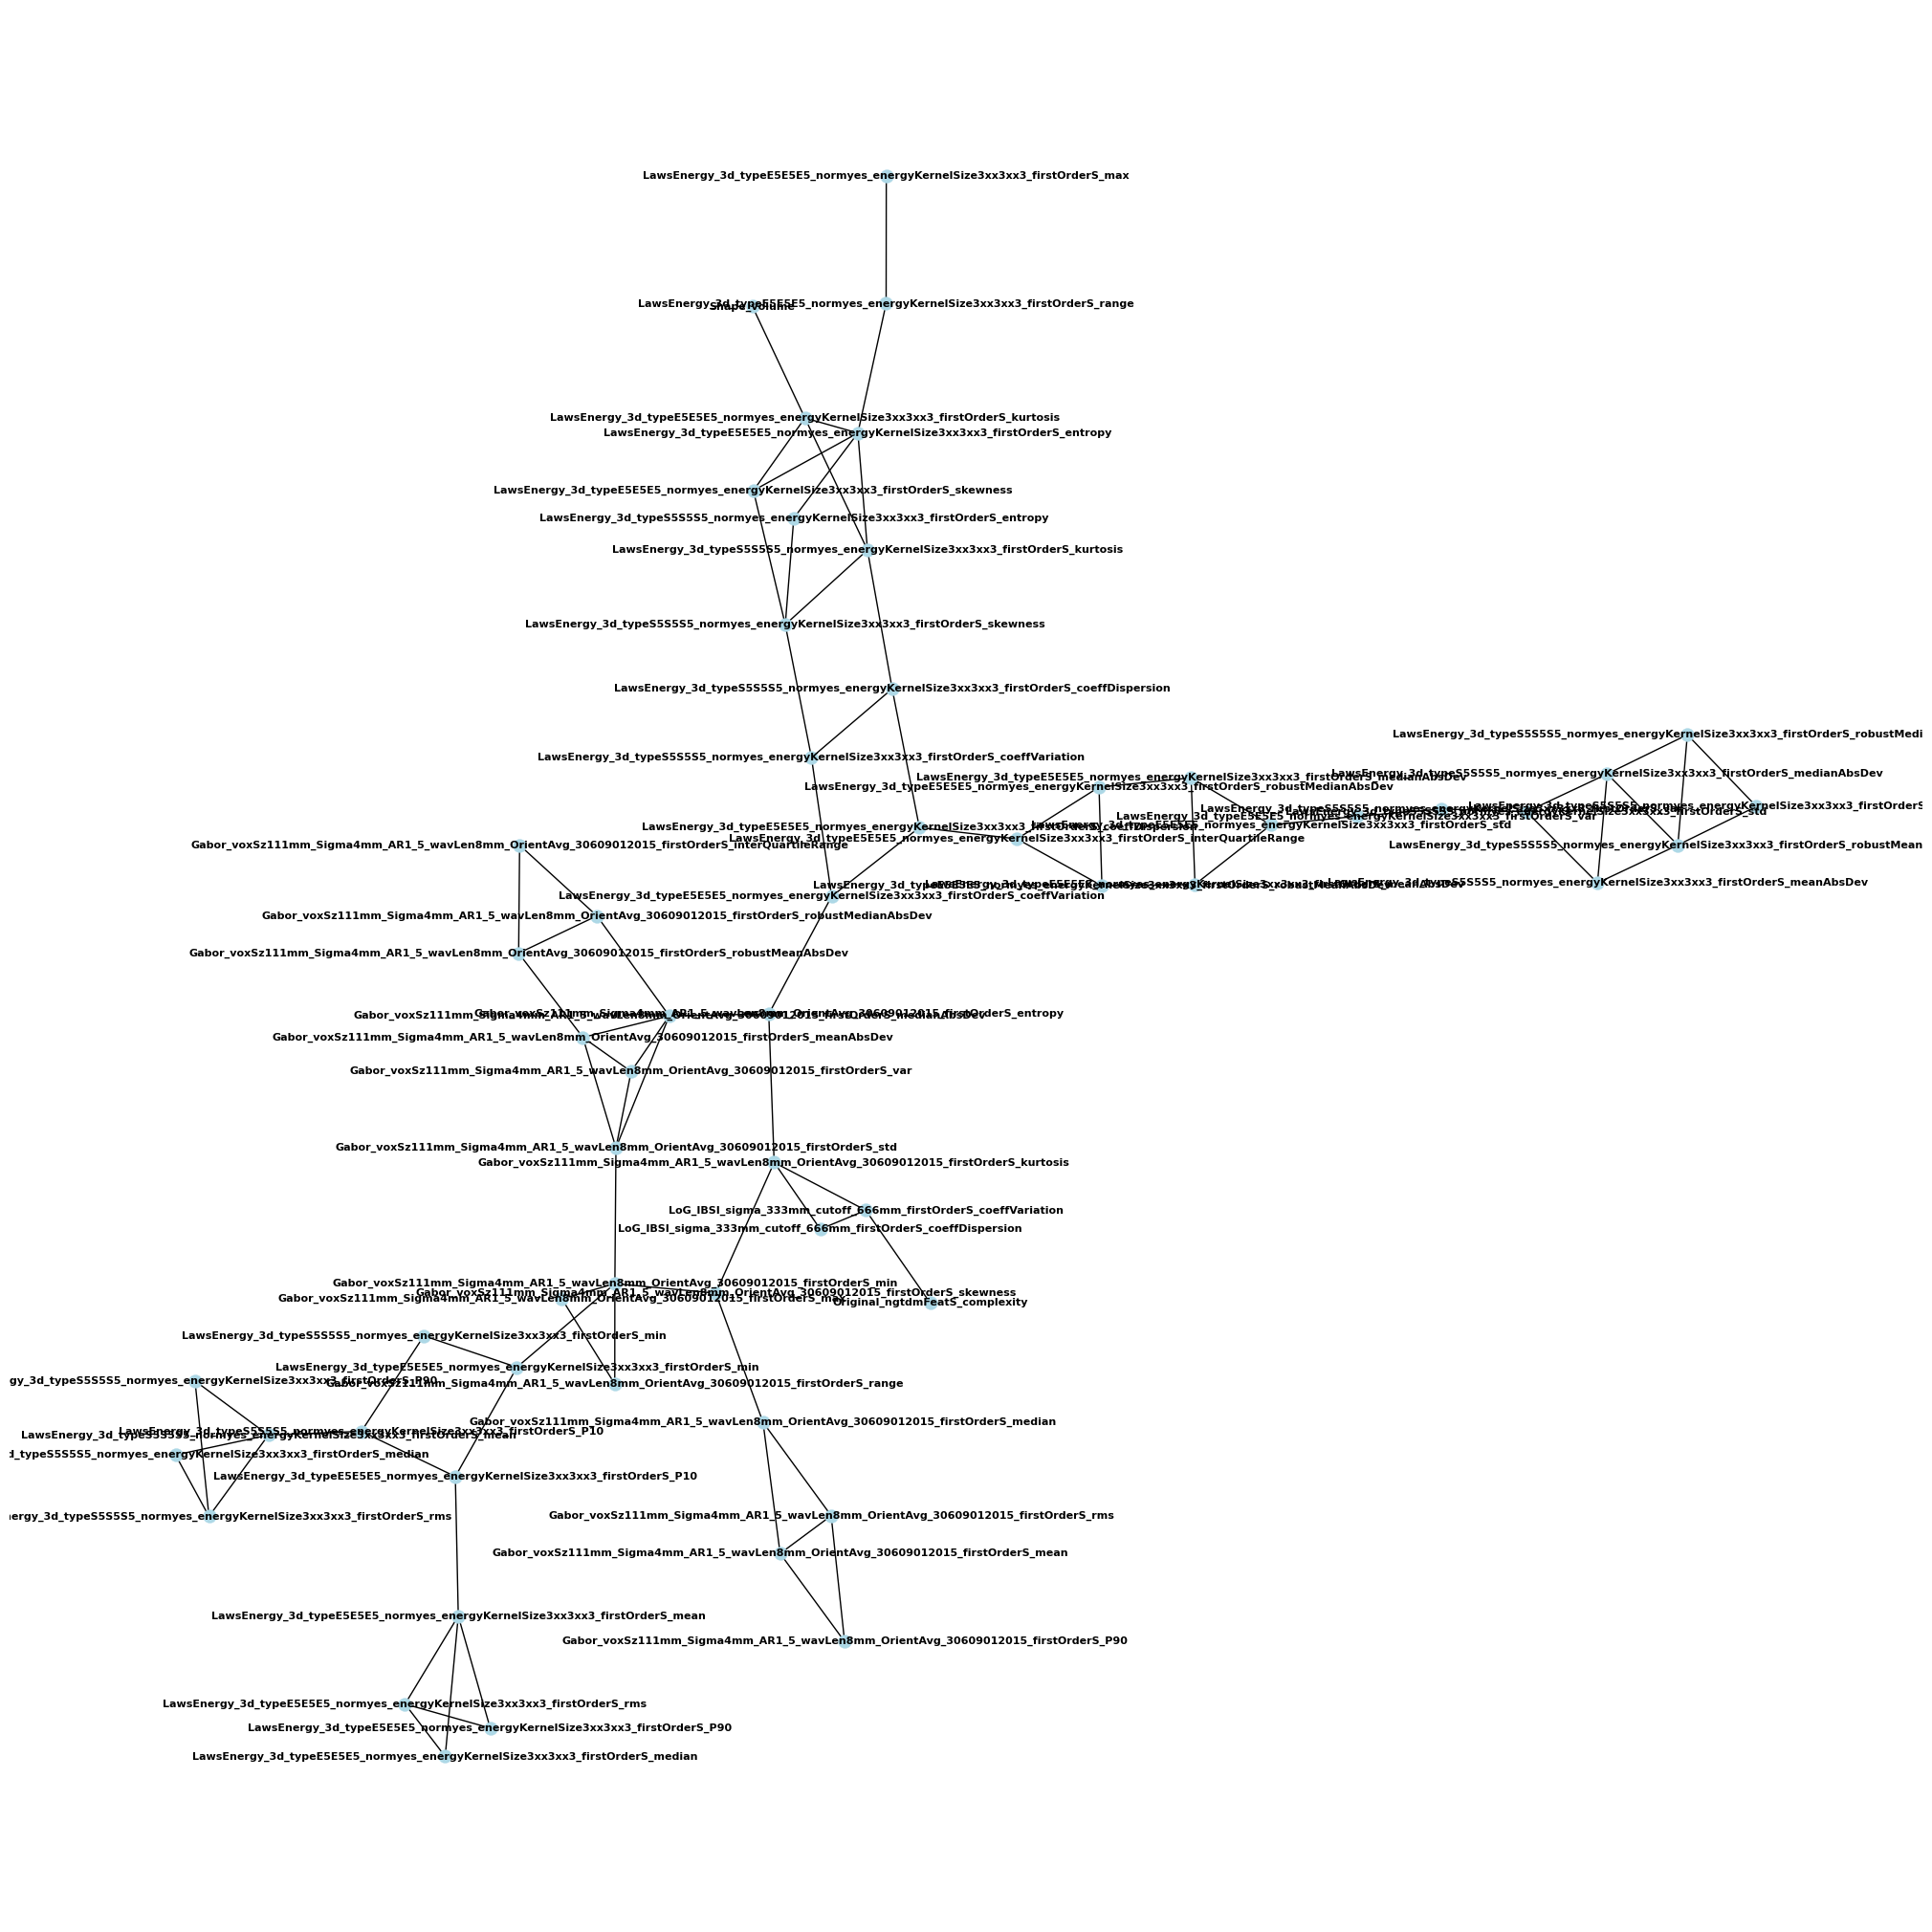

In [10]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0]) # 0: the largest connected network, 1: the second largest one, and so on
plt.figure(2,figsize=(20,20)) 
nx.draw(G0, pos = nx.nx_pydot.graphviz_layout(G0), node_size=100, \
    node_color='lightblue', linewidths=0.25, font_size=8, \
    font_weight='bold', with_labels=True )
adj_G0 = nx.adjacency_matrix(G0)

nodes0=G0.nodes # the largest one
df_G0=df_red[list(nodes0)]
print(adj_G0)

## Print nodes

In [11]:
print(list(nodes0))

['Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_std', 'LawsEnergy_3d_typeE5E5E5_normyes_energyKernelSize3xx3xx3_firstOrderS_coeffDispersion', 'LawsEnergy_3d_typeE5E5E5_normyes_energyKernelSize3xx3xx3_firstOrderS_rms', 'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_var', 'LawsEnergy_3d_typeS5S5S5_normyes_energyKernelSize3xx3xx3_firstOrderS_rms', 'LawsEnergy_3d_typeS5S5S5_normyes_energyKernelSize3xx3xx3_firstOrderS_robustMeanAbsDev', 'LawsEnergy_3d_typeS5S5S5_normyes_energyKernelSize3xx3xx3_firstOrderS_P10', 'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_skewness', 'LoG_IBSI_sigma_333mm_cutoff_666mm_firstOrderS_coeffDispersion', 'Gabor_voxSz111mm_Sigma4mm_AR1_5_wavLen8mm_OrientAvg_30609012015_firstOrderS_rms', 'LawsEnergy_3d_typeE5E5E5_normyes_energyKernelSize3xx3xx3_firstOrderS_robustMeanAbsDev', 'LawsEnergy_3d_typeS5S5S5_normyes_energyKernelSize3xx3xx3_firstOrderS_medianAbsDev', 'LawsEnergy_3d_typ

# Balanced OMT

In [12]:
def dist_cvx(drho,D,m):
    
    # Create two scalar optimization variables.
    u = cp.Variable((m))

    # Form the objective function.
    objective = cp.Minimize(cp.sum(cp.abs(u)))
    
    # Create two constraints.
    constraints = [drho-D@u == 0]

    # Solve the problem.
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return problem.value 

# Functions for Wasserstein distance-based Kmeans

In [13]:
def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

def rsserr(a,b):
    return np.square(np.sum((a-b)**2)) 

def centroid_assignation(G0,gamma,UNBALANCED, dset, centroids, D, m, no_feature):
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            
            if UNBALANCED==1:
              rho0=centroids.iloc[centroid, 0:no_feature].to_numpy()
              rho1=dset.iloc[obs,0:no_feature].to_numpy()

              b=UnbalancedOMT(rho0,rho1,G0,gamma)
              err=b.UnbalancedDistance()
            else:
              #WD
              X2=np.stack((centroids.iloc[centroid, 0:no_feature].to_numpy(), dset.iloc[obs,0:no_feature].to_numpy()))
              X2=np.transpose(X2)

              Node_weights = X2
              S = X2.sum(axis=0) 
              S_copy = np.matlib.repmat(S,no_feature,1)
              Node_Prob = Node_weights/S_copy

              rho0 = Node_Prob[:,0]
              rho1 = Node_Prob[:,1]
              drho = rho0-rho1
              drho = drho-np.average(drho)
              err = dist_cvx(drho,D,m)
            
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

## Wasserstein distance-based Kmeans using unbalanced OMT

In [14]:
def kmeans(G0,gamma,UNBALANCED, dset, k, D, m, no_feature, dis, tol=1e-5): 
    '''
    K-means implementationd for a 
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    '''

    working_dset = dset.copy()
    err = []
    goahead = True
    j = 0
    
    # Initiate clusters by defining centroids 
    centroids = initiate_centroids(k, dset)
    ITER=5 
    while(goahead):
        print(j)
        # Assign centroids and calculate error
        working_dset['centroid'], j_err = centroid_assignation(G0,gamma,UNBALANCED,working_dset, centroids, D, m, no_feature) 
        err.append(sum(j_err))
        
        #  Update centroid position
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # Restart the iteration
        if j>0:
            if np.abs(err[j-1]-err[j])<=tol: 
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(G0,gamma,UNBALANCED,working_dset, centroids, D, m, no_feature)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

    return working_dset['centroid'], j_err, centroids

## Initialization for balanced OMT

In [15]:
T = df_G0.to_numpy()
T = np.transpose(T)
no_sample = T.shape[1]
no_feature = T.shape[0]
print(no_feature)

m = int(round(adj_G0.sum()/2))
print(adj_G0.sum())
print(m)
D = np.zeros((no_feature, m))
count = 0

for i in range(no_feature-1):
    for j in range(i+1,no_feature):
        if adj_G0[i,j]==1:
            D[i,count] = -1
            D[j,count] = 1
            count=count+1

59
172
86


## Run Wasserstein Kmeans 

In [16]:
UNBALANCED = 1
NO_CLUSTER = 2 # number of clusters 
gamma = 30 # paramenter for unblanced OMT
G_0_dis=nx.floyd_warshall_numpy(G0)
df_G0_copy=df_G0.copy()

mapping = dict(zip(G0, range(0, df_G0_copy.shape[1])))
G0 = nx.relabel_nodes(G0, mapping)

df_G0['centroid'], df_G0['error'], centroids =  kmeans(G0,gamma,UNBALANCED,df_G0, NO_CLUSTER, D, m, no_feature, G_0_dis) 

0
1
2
3
4
5
6
7
8
9


<ipython-input-16-edac190fe422>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_G0['centroid'], df_G0['error'], centroids =  kmeans(G0,gamma,UNBALANCED,df_G0, NO_CLUSTER, D, m, no_feature, G_0_dis)
<ipython-input-16-edac190fe422>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_G0['centroid'], df_G0['error'], centroids =  kmeans(G0,gamma,UNBALANCED,df_G0, NO_CLUSTER, D, m, no_feature, G_0_dis)


## Read clinical data

In [17]:
!pip install openpyxl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
df_cli = pd.read_excel("NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.xlsx")
df_all_ids=df_all['id']

df_cli_matched=df_cli.loc[df_cli['Case ID'].isin(df_all_ids)]
df_cli_matched['Histology '].value_counts()

Adenocarcinoma                         88
Squamous cell carcinoma                26
NSCLC NOS (not otherwise specified)     3
Name: Histology , dtype: int64

## Survival analysis

In [19]:
!pip install lifelines
!pip install bioinfokit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 14.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=93159202aa25dd1c36327ddcffb0fff51442967b094fc17b7424d80b97d74507
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bioinfokit: filename=bioinfokit-2.1.0-py3-none-any.whl size=58647 sha256=e6d9ec99666f18cd7e9324df35c908d79ce9985feab6d4b12ee2f3d2cdc9bc62
  Stored in di

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           6.61 0.01      6.63

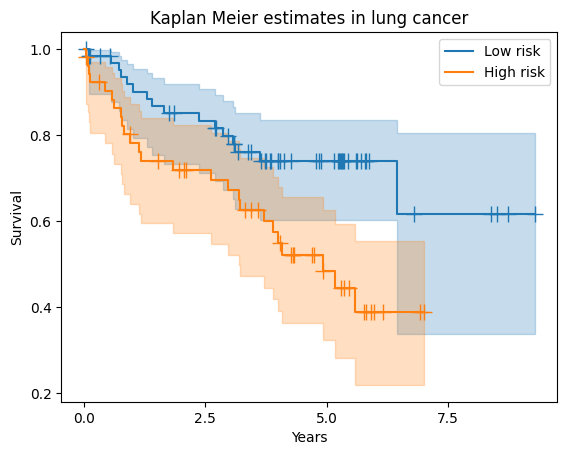

In [20]:
# KM analysis for two clusters
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from matplotlib.offsetbox import AnchoredText
from lifelines import KaplanMeierFitter, CoxPHFitter

OS=df_cli_matched['Survival'].to_numpy()
OS_time=df_cli_matched['Survival time'].to_numpy()

centroid= df_G0['centroid']
idx0= np.where(centroid == 0)
idx1= np.where(centroid == 1)

kmf = KaplanMeierFitter()
ax = plt.subplot(111)
h_OS_time=OS_time[idx0]
h_OS=OS[idx0]
kmf.fit(h_OS_time/365, event_observed = h_OS, label = 'Low risk')
kmf.plot(ax = ax, show_censors=True)

m_OS_time=OS_time[idx1]
m_OS=OS[idx1]
kmf.fit(m_OS_time/365, event_observed = m_OS, label = 'High risk')
kmf.plot(ax = ax, show_censors=True)

plt.title("Kaplan Meier estimates in lung cancer")
plt.xlabel("Years")
plt.ylabel("Survival")
plt.rcParams["figure.figsize"] = (13,8)
plt.rcParams.update({'font.size': 22})

result = multivariate_logrank_test(OS_time, centroid, OS)
result.test_statistic
result.p_value
result.print_summary()

## CIBERSORT analysis betwen the high and low risk groups

B cells naive 0.9685923533307066
B cells memory 0.19381768399808902
Plasma cells 0.08497773653400645
T cells CD8 0.20713563044008165
T cells CD4 naive 0.30265032842719186
T cells CD4 memory resting 0.7272566537816197
T cells CD4 memory activated 0.46277780315091244
T cells follicular helper 0.5560832849223218
T cells regulatory (Tregs) 0.024458838748592136
T cells gamma delta 0.6161842811408822
NK cells resting 0.5252278599396529
NK cells activated 0.8559432965813245
Monocytes 0.036077893466097896
Macrophages M0 0.6531406568311571
Macrophages M1 0.8811828068561438
Macrophages M2 0.879155559531288
Dendritic cells resting 0.0008972965901476742
Dendritic cells activated 0.14900965036117053
Mast cells resting 0.7059675453184395
Mast cells activated 0.01329554777161037
Eosinophils 0.154893862228987
Neutrophils 0.4384335405343601


[Text(0, 0, 'Low risk'), Text(1, 0, 'High risk')]

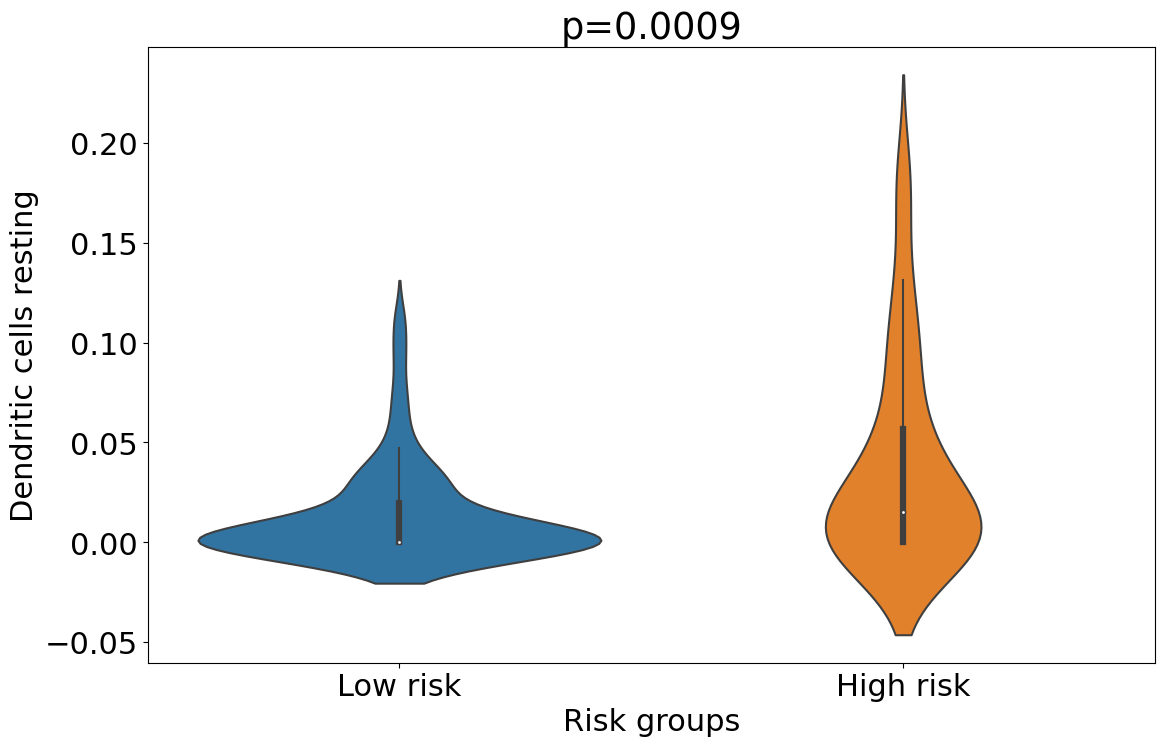

In [21]:
from scipy.stats import ranksums
from scipy.stats import ttest_ind

df_cibersort = pd.read_excel("lung_cibersort_abs.xlsx") 
df_cibersort_matched=df_cibersort.iloc[:,1:23]
df_cibersort_matched['centroid']=centroid

for i in range(22):
  a=df_cibersort_matched.iloc[:,i].to_numpy()
  stat, p = ttest_ind(a=a[idx0], b=a[idx1], equal_var=True)
  print(df_cibersort_matched.columns[i], p)

ax=sns.violinplot(data=df_cibersort_matched, y="Dendritic cells resting", x="centroid")
ax.set(xlabel='Risk groups')
ax.set_title('p=0.0009')
ax.set_xticklabels(['Low risk','High risk']) # 2 clusters